## Loading in the File

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file_path = '/content/drive/Shared drives/MSIS 2534 - NLP Group/Final Project/dataset.csv'

In [ ]:
import pandas as pd
import numpy as np
#df = pd.read_csv(file_path)

## Data Cleaning

### Removing NaNs
There's a sizable number of games who don't have names. These are games that have been removed from the Steam Store and can no longer be purchased.

It's better to remove them.

In [ ]:
#df.head()
num_rows = len(df)
nan_rows = df['app_name'].isna().sum()

print(f"The number of rows is: {num_rows}")
print(f"The number of NaN game rows is: {nan_rows}")

In [ ]:
#Dropping NaN games
df.dropna(subset=['app_name'], inplace=True)

### Removing Non-English Reviews
Since Steam is an international platform, there will be reviews that won't be in english.

Let's remove any review that has any non-latin character.

In [ ]:
num_rows_preclean = len(df)

In [ ]:
#Cleaning Rows for non-latin characters
df = df[df['review_text'].str.contains(r'[^\x00-\x7F]+') == False]

In [ ]:
num_rows_postclean = len(df)

print(f"The number of rows before this clean is: {num_rows_preclean}")
print(f"The number of rows after is: {num_rows_postclean}")

The number of rows before this clean is: 6233872
The number of rows after is: 5758271


### Removing Junk Reviews
Steam's a very, very toxic place with a lot of unhelpful reviews. We should remove any reviews that have less than 30 words to maintain training set purity.

In [ ]:
df['word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Calculate the average word count
average_word_count = df['word_count'].mean()

print(f"The average word count for the 'review_text' column is: {average_word_count}")

The average word count for the 'review_text' column is: 49.28658446259303


In [ ]:
num_rows_preclean = len(df)

#Filtering out the reviews that have less than 30 words
df = df.loc[df['word_count'] >= 30]

num_rows_postclean = len(df)

In [ ]:
print(f"The number of rows before this clean is: {num_rows_preclean}")
print(f"The number of rows after is: {num_rows_postclean}")

The number of rows before this clean is: 5758271
The number of rows after is: 2175107


## Stratifying the Dataset

Since there are some games that have incredibly large followings and review counts, we want to avoid biasing our data to only suggest those specific games.

We'll be stratifying our dataset to take most of the weight any of those "larger" games have.

In [ ]:
df_grouped = df.groupby('app_id', group_keys=False)

# Define a function to perform the stratified split

def stratified_split(group):
    #Change number of samples as needed
    target_samples = 30
    total_samples = len(group)

    # Adjust frac to get exactly 30 (was 150 before, but changed for new smaller dataset) samples for each group
    frac = target_samples / total_samples if total_samples > target_samples else 1.0

    return group.sample(frac=frac, random_state=42)

#def stratified_split(group):
#    return group.sample(frac=0.8, random_state=42)

#df_grouped.apply(stratified_split)
#df_grouped = df_grouped.mean().reset_index()

In [ ]:
df_stratified = df.groupby('app_id', group_keys=False).apply(stratified_split)

# Reset the index to turn it into a normal DataFrame
df_stratified = df_stratified.reset_index(drop=True)

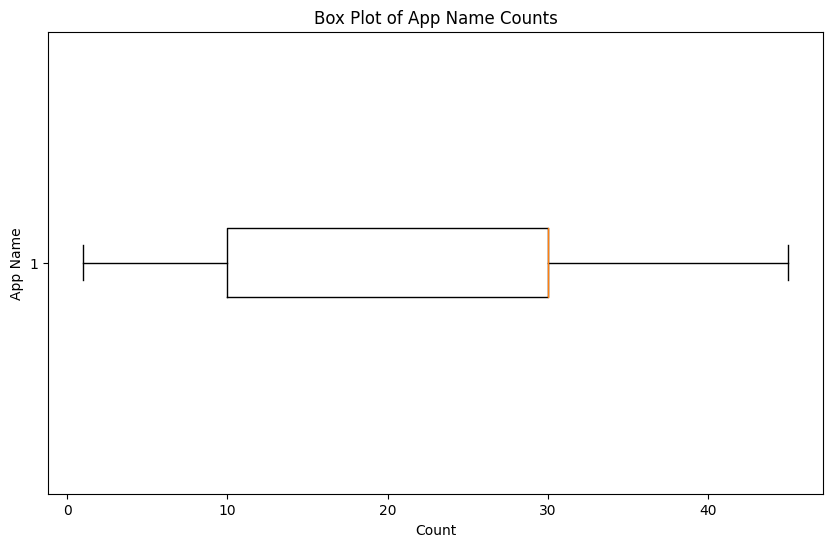

In [ ]:
#Checking for stratification

import matplotlib.pyplot as plt
#df_stratified['app_name'].value_counts()


plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Assuming df is your DataFrame and 'app_name' is the column you want to plot
plt.boxplot(df_stratified['app_name'].value_counts(), vert=False)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('App Name')
plt.title('Box Plot of App Name Counts')

# Show the plot
plt.show()


In [ ]:
df_stratified.head()

,app_id,app_name,review_text,review_score,review_votes,word_count
0,10,Counter-Strike,This is my very first game that I played on St...,1,0,75
1,10,Counter-Strike,About Counter-Strike Counter-Strike is a first...,1,1,201
2,10,Counter-Strike,"It might look like a tiny Half Life mod, but l...",1,0,48
3,10,Counter-Strike,This game is a prime example of how a great ga...,1,0,68
4,10,Counter-Strike,it's good game when you play with you friends ...,1,0,60


## Final Touchups

We'll include the name of the game within the review text.

In [ ]:
df_stratified['review_text_named'] = "" + df_stratified['app_name'] + ": " + df_stratified['review_text']

In [ ]:
print(f"The number of rows post everything: {len(df_stratified)}")


print(f"The number of unique values in 'column_name' is: {df_stratified['app_name'].nunique()}")

The number of rows post everything: 178896
The number of unique values in 'column_name' is: 8483


In [ ]:
df_stratified.head()

,app_id,app_name,review_text,review_score,review_votes,word_count,review_text_named
0,10,Counter-Strike,This is my very first game that I played on St...,1,0,75,Counter-Strike: This is my very first game tha...
1,10,Counter-Strike,About Counter-Strike Counter-Strike is a first...,1,1,201,Counter-Strike: About Counter-Strike Counter-S...
2,10,Counter-Strike,"It might look like a tiny Half Life mod, but l...",1,0,48,Counter-Strike: It might look like a tiny Half...
3,10,Counter-Strike,This game is a prime example of how a great ga...,1,0,68,Counter-Strike: This game is a prime example o...
4,10,Counter-Strike,it's good game when you play with you friends ...,1,0,60,Counter-Strike: it's good game when you play w...


In [ ]:
df_stratified.to_csv('/content/drive/Shared drives/MSIS 2534 - NLP Group/Final Project/SmallStratData.csv') # Export data to csv for training in SageMaker

### Finding Similar Reviews

In [ ]:
import spacy
#import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Given review
given_review = "A shooter game with lots of gore and blood and guts. Made by a good developer, not greedy and no microtransactions. Replayability is a must."

# Tokenize and lemmatize the given review
processed_given_review = " ".join([token.lemma_ for token in nlp(given_review) if not token.is_stop and token.is_alpha])


In [ ]:
#pip install swifter

In [ ]:
# DO NOT RUN THIS, IT TAKES FOREVER
#import swifter
# Tokenize and lemmatize the reviews in the dataframe using swifter for parallel processing
#df_stratified['processed_reviews'] = df_stratified['review_text'].swifter.apply(
#    lambda x: " ".join([token.lemma_ for token in nlp(x) if not token.is_stop and token.is_alpha])
#)

## All you need to run is this code:

In [ ]:
#df_stratified.to_csv('/content/drive/Shared drives/MSIS 2534 - NLP Group/Final Project/tokened_n_lemmatized.csv') # Export data to csv for training in SageMaker

In [ ]:
file_path_strat = '/content/drive/Shared drives/MSIS 2534 - NLP Group/Final Project/tokened_n_lemmatized.csv'
df_stratified = pd.read_csv(file_path_strat)

In [ ]:
df_stratified_clean = df_stratified.dropna(subset=['processed_reviews'])

In [ ]:
# Vectorize the reviews using TF-IDF
vectorizer = TfidfVectorizer()
vectorized_reviews = vectorizer.fit_transform(df_stratified_clean['processed_reviews'])

# Vectorize the given review
vectorized_given_review = vectorizer.transform([processed_given_review])
vectorized_given_review

#scipy.sparse.save_npz('MSIS 2534 - NLP Group/Final Project/vectorized_given_review.npz', vectorized_given_review)

#vectorized_given_review.to_csv('/content/drive/Shared drives/MSIS 2534 - NLP Group/Final Project/vectorized_given_review.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def SimilarReviewGenerator(review):
  reviews= [review]
  vectorizer = TfidfVectorizer()
  vectorized_reviews = vectorizer.fit_transform(df_stratified_clean['processed_reviews'])
  vectorized_given_review = vectorizer.transform(reviews)
  cosine_similarities = cosine_similarity(vectorized_reviews, vectorized_given_review)
  closest_review_index = cosine_similarities.argmax()
  top5_review_indices = np.argsort(cosine_similarities[:, 0])[-5:][::-1]
  print("Given Review:")
  print("Review Text:", review)
  print("\nTop 5 Closest Reviews:")
  for i, index in enumerate(top5_review_indices):
    closest_review_details = df_stratified_clean.loc[index, ['app_name', 'review_text']]
    print(f"\nClosest Game {i + 1} Details:")
    print("App Name:", closest_review_details['app_name'])
    print("Review Text:", closest_review_details['review_text'])

In [ ]:
review = 'Not having steam cloud saves is the only thing wrong with this. Having to restart every time you want to play on a new device sucks!'
SimilarReviewGenerator(review)

Given Review:
Review Text: Not having steam cloud saves is the only thing wrong with this. Having to restart every time you want to play on a new device sucks!

Top 5 Closest Reviews:

Closest Game 1 Details:
App Name: Spandex Force: Champion Rising
Review Text:   I haven't played a more tedious game. For every single thing that you do in the game you have to play the exact same match-3 minigame. Every. Single. Thing. Even during combat. It gets extremely tiring and repetitive. There's also a clock: you have 30 in-game days to complete the mission or you're out of luck.

Closest Game 2 Details:
App Name: Grotesque Tactics: Evil Heroes
Review Text: I wish I could give this game away and purge all record of having bought this game. Even though I bought it when it was 75% off, I still regret having paid even that much for it.

Closest Game 3 Details:
App Name: DOOM 3
Review Text: One thing I gotta say, is that this game is just amazing! I mean when it first came out in 2004 it was like a 

In [ ]:
# Calculate cosine similarity
cosine_similarities = cosine_similarity(vectorized_reviews, vectorized_given_review)

In [ ]:
# Find the index of the closest review
closest_review_index = cosine_similarities.argmax()
closest_review_index

43682

In [ ]:
top5_review_indices = np.argsort(cosine_similarities[:, 0])[-5:][::-1]
top5_review_indices

array([43682, 63625,  4311, 81674, 22381])

In [ ]:
# Find the indices of the top 5 closest reviews
top5_review_indices = np.argsort(cosine_similarities[:, 0])[-5:][::-1]

# Print the details of the given review
print("Given Review:")
print("Review Text:", given_review)

# Print the details of the top 5 closest reviews
print("\nTop 5 Closest Reviews:")
for i, index in enumerate(top5_review_indices):
    closest_review_details = df_stratified_clean.loc[index, ['app_name', 'review_text']]
    print(f"\nClosest Game {i + 1} Details:")
    print("App Name:", closest_review_details['app_name'])
    print("Review Text:", closest_review_details['review_text'])

Given Review:
Review Text: A shooter game with lots of gore and blood and guts. Made by a good developer, not greedy and no microtransactions. Replayability is a must.

Top 5 Closest Reviews:

Closest Game 1 Details:
App Name: Killing Floor 2
Review Text: I remember playing KF 1 a lot but I haven't had much time to play this one as much as I want, so far it have been a great game and I will continue to play it whenever I have time.

Closest Game 2 Details:
App Name: Antisquad
Review Text: This game just barely makes the grade. Lots of potential. But the grinding gets really awful after a while. The rewards gets really tedious to achieve.  I really like the mechanics and the graphics. So I would say, it is worth playing a bit.. but dun expect it to last too long.  6.5 / 10

Closest Game 3 Details:
App Name: Shank
Review Text: Great action 2-D game. A lot of blood and gore. The only two flaws is that it needs more variety in weapon, and the campaign is a little short (but also have a coo